# Natural song segments

Identify natural song segments yielding most distinct responses across models (linear, linear-nonlinear, nonlinear adaptive).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from aux import get_seg, load_npy
from disp import set_plot

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

NTR = 276
PFX_LIN = f'data/simple/mlv/neur_basic/baker_lin/mlv_baker_lin'
PFX_LN = f'data/simple/mlv/neur_basic/baker_ln/mlv_baker_ln'
PFX_MA = f'data/simple/mlv/neur_basic/baker_ma/mlv_baker_ma'

NR = 224
R_COLS = [f'R_{cr}' for cr in range(NR)]

WDW = 60
IWDW = int(round(WDW/DT))

In [2]:
def to_block_repr(df):
    """Convert vector time-series representation of song to block representation."""
    s = np.array(df['S']).astype(bool)
    p = np.array(df['P']).astype(bool)
    q = ~(s | p)
    
    q_segs = get_seg(q, min_gap=1)[1]*DT
    s_segs = get_seg(s, min_gap=1)[1]*DT
    p_segs = get_seg(p, min_gap=1)[1]*DT
    
    if len(q_segs) == 0:
        q_segs = q_segs.reshape((0, 2))
    if len(s_segs) == 0:
        s_segs = s_segs.reshape((0, 2))
    if len(p_segs) == 0:
        p_segs = p_segs.reshape((0, 2))
    
    q_starts = q_segs[:, 0]
    s_starts = s_segs[:, 0]
    p_starts = p_segs[:, 0]
    all_starts = cc([q_starts, s_starts, p_starts])
    
    q_durs = q_segs[:, 1] - q_segs[:, 0]
    s_durs = s_segs[:, 1] - s_segs[:, 0]
    p_durs = p_segs[:, 1] - p_segs[:, 0]
    all_durs = cc([q_durs, s_durs, p_durs])
    
    all_modes = cc([np.repeat('Q', len(q_durs)), np.repeat('S', len(s_durs)), np.repeat('P', len(p_durs))])
    
    idxs_sorted = np.argsort(all_starts)
    
    durs_sorted = all_durs[idxs_sorted]
    modes_sorted = all_modes[idxs_sorted]
    
    return pd.DataFrame(columns=['DURATION', 'MODE'], data={'DURATION': durs_sorted, 'MODE': modes_sorted})

# Artificial song segments

In [3]:
t = np.arange(0, 30, DT)

# stim 1 (QSQ)
s = np.zeros(t.shape)
p = np.zeros(t.shape)

s[(10 <= t) & (t < 20)] = True

df = pd.DataFrame(columns=['T', 'S', 'P'], data={'T': t, 'S': s, 'P': p})
to_block_repr(df).to_csv(f'data/stimuli/block_stim_1.csv', index=False)

# stim 2 (QPQ)
s = np.zeros(t.shape)
p = np.zeros(t.shape)

p[(10 <= t) & (t < 20)] = True

df = pd.DataFrame(columns=['T', 'S', 'P'], data={'T': t, 'S': s, 'P': p})
to_block_repr(df).to_csv(f'data/stimuli/block_stim_2.csv', index=False)


t = np.arange(0, 50, DT)

# stim 3 (QSPSQ)
s = np.zeros(t.shape)
p = np.zeros(t.shape)

s[(10 <= t) & (t < 20)] = True
p[(20 <= t) & (t < 30)] = True
s[(30 <= t) & (t < 40)] = True

df = pd.DataFrame(columns=['T', 'S', 'P'], data={'T': t, 'S': s, 'P': p})
to_block_repr(df).to_csv(f'data/stimuli/block_stim_3.csv', index=False)

# stim 4 (QPSPQ)
s = np.zeros(t.shape)
p = np.zeros(t.shape)

p[(10 <= t) & (t < 20)] = True
s[(20 <= t) & (t < 30)] = True
p[(30 <= t) & (t < 40)] = True

df = pd.DataFrame(columns=['T', 'S', 'P'], data={'T': t, 'S': s, 'P': p})
to_block_repr(df).to_csv(f'data/stimuli/block_stim_4.csv', index=False)

# Natural song segments

In [4]:
# compute scores for trials/time windows based on distinguishability of neural responses
scores = []
coords = []

# loop over trials
for ctr in range(NTR):
    sys.stdout.write('.')
    df_lin = load_npy(f'{PFX_LIN}_tr_{ctr}.npy')['df']
    df_ln = load_npy(f'{PFX_LN}_tr_{ctr}.npy')['df']
    df_ma = load_npy(f'{PFX_MA}_tr_{ctr}.npy')['df']

    t = df_lin['T']
    
    nt = len(df_lin)
    
    q = np.array(df_lin['Q']).astype(bool)
    s = np.array(df_lin['S']).astype(bool)
    p = np.array(df_lin['P'] | df_lin['F']).astype(bool)
    
    song = {'q': q, 's': s, 'p': p}
    
    r_lin = np.array(df_lin[R_COLS])
    r_ln = np.array(df_ln[R_COLS])
    r_ma = np.array(df_ma[R_COLS])
    
    # loop over time windows
    for it in range(0, nt, IWDW):
        r_lin_wdw = r_lin[it:it+IWDW]
        r_ln_wdw = r_ln[it:it+IWDW]
        r_ma_wdw = r_ma[it:it+IWDW]
        
        # get average median difference between each pair of model responses
        diff_lin_ln = np.mean(np.nanmedian((r_lin_wdw - r_ln_wdw)**2, axis=1))
        diff_lin_ma = np.mean(np.nanmedian((r_lin_wdw - r_ma_wdw)**2, axis=1))
        diff_ln_ma = np.mean(np.nanmedian((r_ln_wdw - r_ma_wdw)**2, axis=1))
        
        score = np.mean([diff_lin_ln, diff_lin_ma, diff_ln_ma])
        scores.append([score, diff_lin_ln, diff_lin_ma, diff_ln_ma])
        coords.append((ctr, it))
        
scores = np.array(scores)

....................................................................................................................................................................................................................................................................................

In [5]:
len(scores)

2886

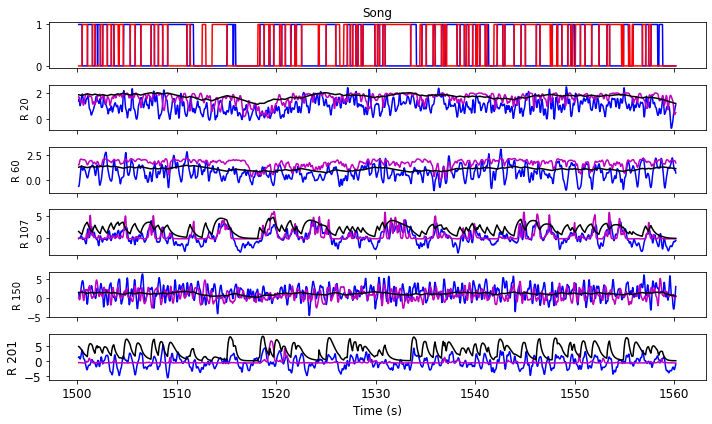

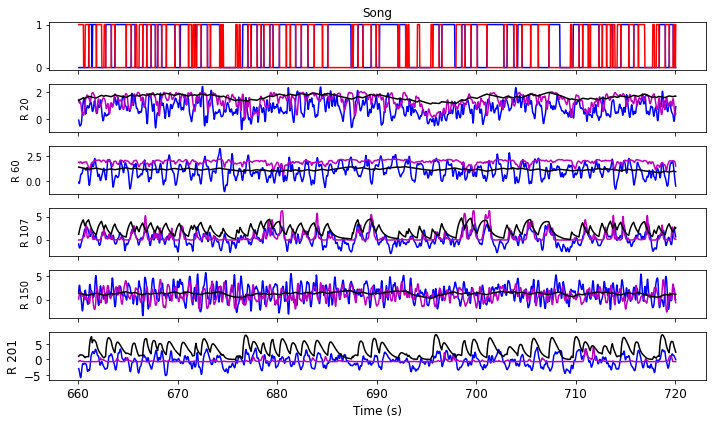

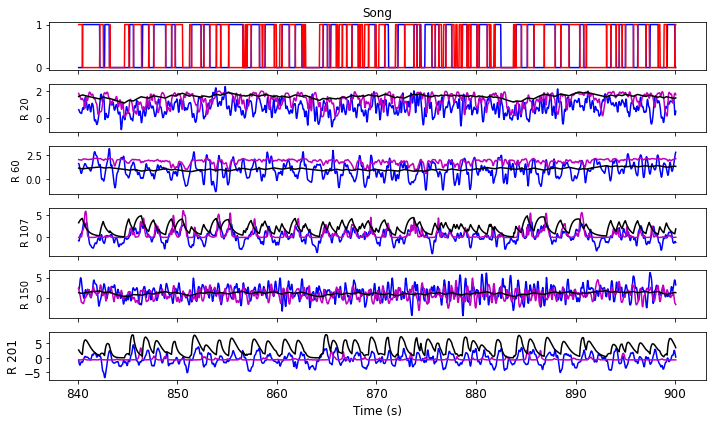

In [6]:
# identify best time windows
idxs_sorted = np.argsort(scores[:, 0])[::-1]
IRS_PLOT = [20, 60, 107, 150, 201]

dfs_save = []

for cidx, idx in enumerate(idxs_sorted[:3]):
    fig, axs = plt.subplots(6, 1, figsize=(10, 6), tight_layout=True, sharex=True)
    ctr, it = coords[idx]
    
    df_lin = load_npy(f'{PFX_LIN}_tr_{ctr}.npy')['df']
    df_ln = load_npy(f'{PFX_LN}_tr_{ctr}.npy')['df']
    df_ma = load_npy(f'{PFX_MA}_tr_{ctr}.npy')['df']
    
    t = np.array(df_lin['T'])[it:it+IWDW]
    
    q = np.array(df_lin['Q']).astype(bool)[it:it+IWDW]
    s = np.array(df_lin['S']).astype(bool)[it:it+IWDW]
    p = np.array(df_lin['P'] | df_lin['F']).astype(bool)[it:it+IWDW]
    
    song = {'q': q, 's': s, 'p': p}
    
    r_lin = np.array(df_lin[R_COLS])[it:it+IWDW, :]
    r_ln = np.array(df_ln[R_COLS])[it:it+IWDW, :]
    r_ma = np.array(df_ma[R_COLS])[it:it+IWDW, :]
    
    axs[0].plot(t, s, c='b')
    axs[0].plot(t, p, c='r')
    axs[0].set_title('Song')
    
    for ax, ir_plot in zip(axs[1:], IRS_PLOT):
        ax.plot(t, r_lin[:, ir_plot], c='b')
        ax.plot(t, r_ln[:, ir_plot], c='m')
        ax.plot(t, r_ma[:, ir_plot], c='k')
        
        ax.set_ylabel(f'R {ir_plot}')
        
    set_plot(axs[-1], x_label='Time (s)', font_size=12)
    
    df = pd.DataFrame(columns=['T', 'S', 'P'], data={'T': t-t[0], 'S': s.astype(int), 'P': p.astype(int)})
    to_block_repr(df).to_csv(f'data/stimuli/natural_stim_{cidx+1}.csv', index=False)